### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import time as time
from numpy import apply_along_axis
# General data management
import numpy as np
from numpy.linalg import inv
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.datasets import load_digits
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
import pydot
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-10-10 09:29:12.522613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 09:29:12.522645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# reading the output from MOBO
constraint_model = pd.read_csv('constraint_model_materialCAT.csv', index_col=[0])
full_df = pd.read_csv('FJH_ML_Final.csv', header=1)
# create extra variables 
def categorize_gyield (df, target, threshold):
    yield_cat = []
    for i in range(0, len(df)):
        if df[target].iloc[i] <= threshold:
            yield_cat.append(0)
        else:
            yield_cat.append(1)
    target_cat = target + '_Cat'
    df[target_cat] = yield_cat
    return df[target_cat]

threshold_GYield = 52
constraint_model ['GYield_Cat'] = categorize_gyield (df=constraint_model, 
                                                     target='GYield', 
                                                     threshold=threshold_GYield)
threshold_Yield = 82
constraint_model ['Yield_Cat'] =  categorize_gyield (df=constraint_model, 
                                                     target='Yield', 
                                                     threshold=threshold_Yield)
constraint_model ['charge_density'] = constraint_model ['cap']*\
                                      constraint_model ['volt']/\
                                      constraint_model ['mass']
print ('# of samples Yield  <= {}% in group 0:{}'.format (threshold_Yield, 
                                                       sum (constraint_model['Yield_Cat']==0)))
print ('# of samples Yield  >  {}% in group 1:{}'.format (threshold_Yield, 
                                                       sum (constraint_model['Yield_Cat']==1)))
print ('# of samples GYield <= {}% in group 0:{}'.format (threshold_GYield, 
                                                       sum (constraint_model['GYield_Cat']==0)))
print ('# of samples GYield >  {}% in group 1:{}'.format (threshold_GYield, 
                                                       sum (constraint_model['GYield_Cat']==1)))

constraint_model ['I_Max_norm'] = np.array (constraint_model['I_Max']/constraint_model['mass'])
constraint_model ['charge_tot_norm'] = constraint_model['charge_tot']/(constraint_model['mass'])*1000
constraint_model ['I_Final_perc'] = np.array (constraint_model['I_Final']/constraint_model['I_Max'])
constraint_model.columns

# of samples Yield  <= 82% in group 0:86
# of samples Yield  >  82% in group 1:88
# of samples GYield <= 52% in group 0:84
# of samples GYield >  52% in group 1:90


Index(['R1_CB', 'R1_MC', 'R1_PA', 'cap', 'volt', 'mass', 'ptime', 'pre_volt',
       'pre_peak', 'I_Max', 'charge_tot', 'I_Final', 'GYield', 'Yield',
       'Material', 'GYield_Cat', 'Yield_Cat', 'charge_density', 'I_Max_norm',
       'charge_tot_norm', 'I_Final_perc'],
      dtype='object')

In [3]:
# assign integers to group names 
# (CB, MC, PA, TCB)-->(0, 1, 2, 3)
constraint_model ['Material_group'] = [0 if sample=='CB' else 
                                       sample for sample in constraint_model ['Material']]
constraint_model ['Material_group'] = [1 if sample=='MC' else 
                                       sample for sample in constraint_model ['Material_group']]
constraint_model ['Material_group'] = [2 if sample=='PA' else 
                                       sample for sample in constraint_model ['Material_group']]
constraint_model ['Material_group'] = [3 if sample=='TCB' else 
                                       sample for sample in constraint_model ['Material_group']]

Input features:  Index(['I_Max', 'charge_tot', 'I_Final', 'GYield', 'Yield'], dtype='object')


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


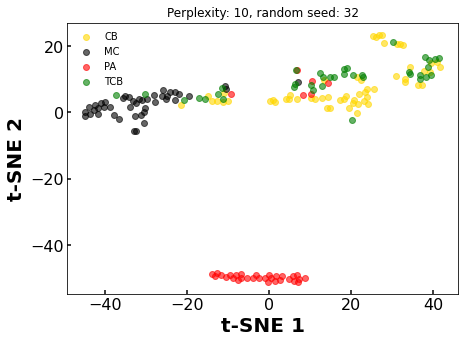

In [4]:
##### using precursor material group as classes. !!!!!!!!!!!!
# keep the best of t-SNE
# only consider the current-time information and the Yield and GYield (5 input)
# using precursor material group as classes.

# best options: (perplexity, rand)
# [(7, 29), (7, 30), (7, 39), (8, 34), (8, 40),
# (8, 43), (8, 48), (9, 13), (9, 24), (9, 35),
# (9, 40), (9, 43), (10, 19), (10, 21), (10, 24)
# (10, 32)]
features_dimred = constraint_model.iloc[:, 9:14]
print ('Input features: ', features_dimred.columns)
colors = ['gold', 'black', 'red', 'green']
# 4 groups of precursors
target_ids = list(range(4))
group_names_gen = ['CB', 'MC', 'PA', 'TCB']
Material = constraint_model ['Material_group']
for per in range (10, 11):
    for rand in range (32, 33):  
        fig, ax = plt.subplots(figsize=(7,5))
        ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='16')
        for i, c, label in zip(target_ids, colors, group_names_gen): 
            tSNE_embedded = TSNE(n_components=2, init='random', metric='euclidean',learning_rate=200,
                            perplexity=per, random_state=rand).fit_transform(features_dimred)

            plt.scatter(tSNE_embedded[Material==i, 0], 
                    tSNE_embedded[Material==i, 1], 
                    c=c, alpha=0.6, label=label)

            pyplot.xlabel('t-SNE 1', fontname="Arial", fontsize="20", fontweight = "bold")
            pyplot.ylabel('t-SNE 2', fontname="Arial", fontsize="20", fontweight = "bold")
        plt.title ('Perplexity: {}, random seed: {}'.format(per, rand))   
        plt.legend(fontsize="10", frameon=False)
        plt.savefig('tsne_materialgroup.png', dpi=300)
        plt.show()

In [5]:
currents_dimred = constraint_model.iloc[:, 9:12]
currents_dimred
pca = PCA(n_components=3)
pca_fit = pca.fit(currents_dimred)
transformed = pca_fit.transform(currents_dimred)
print (pca_fit.explained_variance_ratio_)


[8.90384951e-01 1.09003852e-01 6.11196649e-04]


Input features:  Index(['I_Max', 'charge_tot', 'I_Final'], dtype='object')


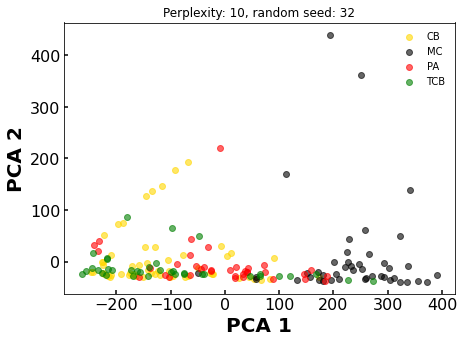

In [6]:
##### using precursor material group as classes. !!!!!!!!!!!!
# keep the best of PCA (even after using whiten to scale it, does not show good result)
# only consider the current-time information and the Yield and GYield (5 input)
# using precursor material group as classes.
# best options: (perplexity, rand)
# [(7, 29), (7, 30), (7, 39), (8, 34), (8, 40),
# (8, 43), (8, 48), (9, 13), (9, 24), (9, 35),
# (9, 40), (9, 43), (10, 19), (10, 21), (10, 24)
# (10, 32)]
features_dimred = constraint_model.iloc[:, 9:12]
print ('Input features: ', features_dimred.columns)
colors = ['gold', 'black', 'red', 'green']
# 4 groups of precursors
target_ids = list(range(4))
group_names_gen = ['CB', 'MC', 'PA', 'TCB']
Material = constraint_model ['Material_group']
for per in range (10, 11):
    for rand in range (32, 33):  
        fig, ax = plt.subplots(figsize=(7,5))
        ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='16')
        for i, c, label in zip(target_ids, colors, group_names_gen): 
            PCA_embedded = PCA(n_components=2, whiten=False).fit_transform(features_dimred)

            plt.scatter(PCA_embedded[Material==i, 0], 
                    PCA_embedded[Material==i, 1], 
                    c=c, alpha=0.6, label=label)

            pyplot.xlabel('PCA 1', fontname="Arial", fontsize="20", fontweight = "bold")
            pyplot.ylabel('PCA 2', fontname="Arial", fontsize="20", fontweight = "bold")
        plt.title ('Perplexity: {}, random seed: {}'.format(per, rand))   
        plt.legend(fontsize="10", frameon=False)
        plt.savefig('PCA_materialgroup.png', dpi=300)
        plt.show()

In [7]:
# simple linear regression
current_matrix = constraint_model.iloc[:, 9:12]
current_matrix = np.array (current_matrix)
pca = PCA(n_components=1, whiten=True)

pca_fit = pca.fit(current_matrix)
current_vector = pca.fit_transform(current_matrix)
current_vector.shape

material_matrix = constraint_model.iloc[:, 0:3]
material_matrix = np.array (material_matrix)

(174, 1)
[[ 50.98066933]
 [337.05870224]
 [ 80.37824514]
 [ 13.16119636]
 [ -6.81696138]
 [  1.27080981]]
(35, 1)
0.6646029227015495
mse:  9882.764766030537


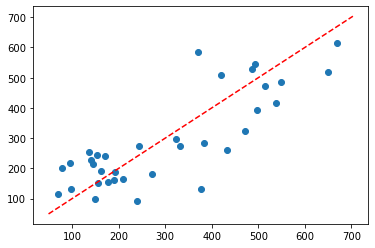

In [8]:
# I_Max as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> I_Max
# It works for charge_total (area under I-t curve)
# It is not working for I_Final
I_Max = np.array (constraint_model.iloc[:, 9:10])

material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (full_df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (full_df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (full_df['Volt_Drop']).reshape (-1, 1)

print (Init_R.shape)
input_features = np.concatenate((material_matrix, Init_R, Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    input_features, I_Max, test_size = 0.2, random_state=0)

# Compute beta
Xt = np.transpose(X_train)
XtX = np.dot(Xt,X_train)
Xty = np.dot(Xt,y_train)
beta = np.linalg.solve(XtX,Xty)
print(beta)

y_pred = np.dot(X_test, beta)
print (y_pred.shape)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print (r2)

print ('mse: ', mean_squared_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
mid_line = list(np.linspace(np.min(I_Max), np.max(I_Max), 8))
plt.plot(mid_line, mid_line, '--', color='red')

(174, 1)
(174, 1)
coef_:  [-0.41527823  0.38638475  0.1643062  -0.03721069 -0.01476537  0.00399127]
0.7050609356221635
mse:  12218.905369846381


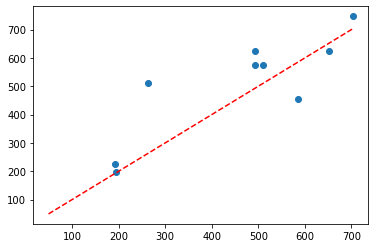

In [9]:
# I_Max as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> I_Max
# It works for charge_total (area under I-t curve)
# It is not working for I_Final

I_Max = np.array (constraint_model.iloc[:, 9:10])
print (I_Max.shape)

material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (full_df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (full_df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (full_df['Volt_Drop']).reshape (-1, 1)

print (Init_R.shape)
input_features = np.concatenate((material_matrix, Init_R, Res_Drop, Volt_Drop), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    input_features, I_Max, test_size = 0.05, random_state=200)

clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
y_pred = clf.predict (X_test)
print (clf.score(X_test, y_test.ravel()))
print ('mse: ', mean_squared_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
mid_line = list(np.linspace(np.min(I_Max), np.max(I_Max), 8))
plt.plot(mid_line, mid_line, '--', color='red')

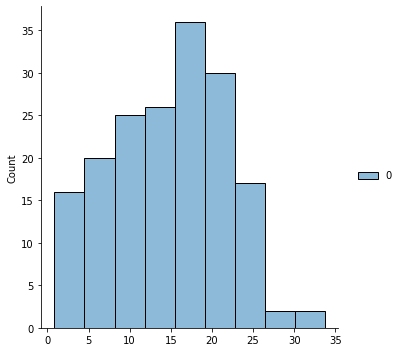

In [19]:
I_Final = np.array (constraint_model.iloc[:, 10:11])
sns.displot(I_Final)

[[-0.54405875]
 [-0.04187594]
 [ 1.89779879]
 [ 0.43413026]]
(35, 1)
0.641647746610737


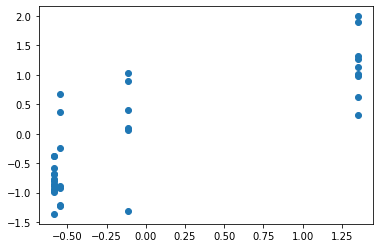

In [11]:
# add bias to the model
first_column = np.empty(shape=(material_matrix.shape[0], 1))
first_column[:,:] = 1
material4_matrix = material_matrix.copy()
material4_matrix = np.concatenate ((first_column, material4_matrix), axis=1)
I_Max = np.array (constraint_model.iloc[:, 11:12])


X_train, X_test, y_train, y_test = train_test_split(
    material4_matrix, current_vector, test_size = 0.20, random_state=0)


# Compute beta
Xt = np.transpose(X_train)
XtX = np.dot(Xt,X_train)
Xty = np.dot(Xt,y_train)
beta = np.linalg.solve(XtX,Xty)
print(beta)

y_pred = np.dot(X_test, beta)
print (y_pred.shape)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print (r2)
plt.scatter(y_pred, y_test)

[[-0.54405875]
 [-0.04187594]
 [ 1.89779879]
 [ 0.43413026]]
(35, 1)
0.641647746610737


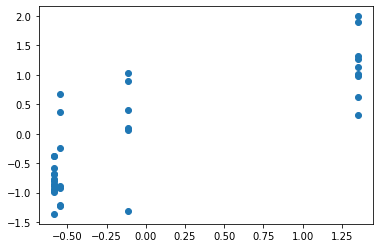

In [12]:
# add bias to the model
I_Max = np.array (constraint_model.iloc[:, 11:12])

X_train, X_test, y_train, y_test = train_test_split(
    material4_matrix, current_vector, test_size = 0.20, random_state=0)


# Compute beta
Xt = np.transpose(X_train)
XtX = np.dot(Xt,X_train)
Xty = np.dot(Xt,y_train)
beta = np.linalg.solve(XtX,Xty)
print(beta)

y_pred = np.dot(X_test, beta)
print (y_pred.shape)
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print (r2)
plt.scatter(y_pred, y_test)

In [13]:
# add bias to the model
first_column = np.empty(shape=(material_matrix.shape[0], 1))
first_column[:,:] = 1
material4_matrix = material_matrix.copy()
material4_matrix = np.concatenate ((first_column, material4_matrix), axis=1)
I_Max = np.array (constraint_model.iloc[:, 11:12])


X_train, X_test, y_train, y_test = train_test_split(
    material4_matrix, I_Max, test_size = 0.20, random_state=0)

In [14]:
last_column = np.empty(shape=(material_matrix.shape[0], 1))
last_column[:,:] = 0
material4_matrix = material_matrix.copy()

material4_matrix = np.concatenate ((material4_matrix, last_column), axis=1)
#material4_matrix = [1 if np.all(s)==0 else s for s in np.apply_along_axis(material4_matrix, )]

def add_lastmaterial(x):
    if np.any(x)==0:
        x[-1]=1
    return x
material4_matrix = np.apply_along_axis(add_lastmaterial, axis=1, arr=material4_matrix)
material4_matrix
reg = LinearRegression().fit(material4_matrix, current_vector)
print (reg.score(material4_matrix, current_vector))
print (reg.coef_)
print (reg.intercept_)
print (reg.get_params())

0.6338562699073527
[[1.24001648e+13 1.24001648e+13 1.24001648e+13 1.24001648e+13]]
[-1.24001648e+13]
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


Input features:  Index(['R1_CB', 'R1_MC', 'R1_PA', 'cap', 'volt', 'mass', 'ptime', 'pre_volt',
       'pre_peak', 'I_Max', 'charge_tot', 'I_Final'],
      dtype='object')


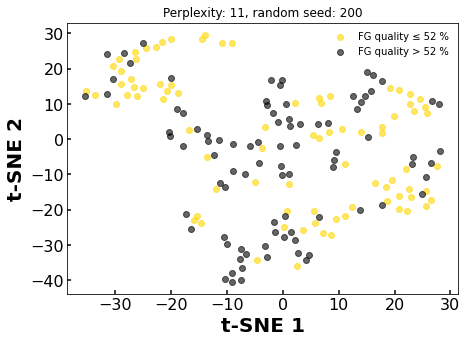

In [15]:
##### using GYield group (>52%) as classes. !!!!!!!!!!!!
# Consider all the input parameters and current-time information 
# best options: (perplexity, rand)

features_dimred = constraint_model.iloc[:, 0:12]
print ('Input features: ', features_dimred.columns)
colors = ['gold', 'black']
# 4 groups of precursors
target_ids = list(range(4))
group_names_gen = ['FG quality ≤ {} %'.format(threshold_GYield), 'FG quality > {} %'.format(threshold_GYield)]
GYield_cat = constraint_model ['GYield_Cat']
for per in range (11, 12):
    for rand in range (200, 201):  
        fig, ax = plt.subplots(figsize=(7,5))
        ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='16')
        for i, c, label in zip(target_ids, colors, group_names_gen): 
            tSNE_embedded = TSNE(n_components=2, init='random', metric='euclidean',learning_rate=200,
                            perplexity=per, random_state=rand).fit_transform(features_dimred)

            plt.scatter(tSNE_embedded[GYield_cat==i, 0], 
                    tSNE_embedded[GYield_cat==i, 1], 
                    c=c, alpha=0.6, label=label)

            pyplot.xlabel('t-SNE 1', fontname="Arial", fontsize="20", fontweight = "bold")
            pyplot.ylabel('t-SNE 2', fontname="Arial", fontsize="20", fontweight = "bold")
        plt.title ('Perplexity: {}, random seed: {}'.format(per, rand))   
        plt.legend(fontsize="10", frameon=False)
        plt.savefig('tsne_FGquality_group.png', dpi=300)
        plt.show()

In [16]:
# (material*FG quality) groups
constraint_model ['Material_GY_group'] = [
    0 if sample=='CB' and gyield==0 else 
         sample for (sample, gyield) in zip(constraint_model ['Material'], constraint_model['GYield_Cat'])]
constraint_model ['Material_GY_group'] = [1 if sample=='CB' else 
                                       sample for sample in constraint_model ['Material_GY_group']]

constraint_model ['Material_GY_group'] = [
    2 if sample=='MC' and gyield==0 else 
         sample for (sample, gyield) in zip(constraint_model ['Material_GY_group'], constraint_model['GYield_Cat'])]
constraint_model ['Material_GY_group'] = [3 if sample=='MC' else 
                                       sample for sample in constraint_model ['Material_GY_group']]

constraint_model ['Material_GY_group'] = [
    4 if sample=='PA' and gyield==0 else 
         sample for (sample, gyield) in zip(constraint_model ['Material_GY_group'], constraint_model['GYield_Cat'])]
constraint_model ['Material_GY_group'] = [5 if sample=='PA' else 
                                       sample for sample in constraint_model ['Material_GY_group']]

constraint_model ['Material_GY_group'] = [
    6 if sample=='TCB' and gyield==0 else 
         sample for (sample, gyield) in zip(constraint_model ['Material_GY_group'], constraint_model['GYield_Cat'])]
constraint_model ['Material_GY_group'] = [7 if sample=='TCB' else 
                                       sample for sample in constraint_model ['Material_GY_group']]

Input features:  Index(['I_Max', 'charge_tot', 'I_Final', 'GYield', 'Yield'], dtype='object')


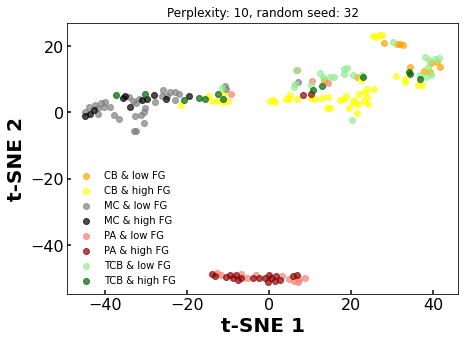

In [17]:
##### using (material * FG quality) as classes. !!!!!!!!!!!!
# keep the best of t-SNE
# only consider the current-time information and the Yield and GYield (5 input)
# using precursor material group as classes.

# best options: (perplexity, rand)
# [(7, 29), (7, 30), (7, 39), (8, 34), (8, 40),
# (8, 43), (8, 48), (9, 13), (9, 24), (9, 35),
# (9, 40), (9, 43), (10, 19), (10, 21), (10, 24)
# (10, 32)]
features_dimred = constraint_model.iloc[:, 9:14]
print ('Input features: ', features_dimred.columns)
colors = ['orange', 'yellow',
          'grey', 'black',
          'salmon', 'darkred',
          'lightgreen', 'darkgreen']
# 4 groups of precursors
target_ids = list(range(8))
group_names_gen = ['CB & low FG', 'CB & high FG',
                   'MC & low FG', 'MC & high FG',
                   'PA & low FG', 'PA & high FG',
                   'TCB & low FG','TCB & high FG']
MaterialTFG_groups = constraint_model ['Material_GY_group']
for per in range (10, 11):
    for rand in range (32, 33):  
        fig, ax = plt.subplots(figsize=(7,5))
        ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='16')
        for i, c, label in zip(target_ids, colors, group_names_gen): 
            tSNE_embedded = TSNE(n_components=2, init='random', metric='euclidean',learning_rate=200,
                            perplexity=per, random_state=rand).fit_transform(features_dimred)

            plt.scatter(tSNE_embedded[MaterialTFG_groups==i, 0], 
                    tSNE_embedded[MaterialTFG_groups==i, 1], 
                    c=c, alpha=0.7, label=label)

            pyplot.xlabel('t-SNE 1', fontname="Arial", fontsize="20", fontweight = "bold")
            pyplot.ylabel('t-SNE 2', fontname="Arial", fontsize="20", fontweight = "bold")
        plt.title ('Perplexity: {}, random seed: {}'.format(per, rand))   
        plt.legend(fontsize="10", frameon=False)
        plt.savefig('tsne_material_FG_group.png', dpi=300)
        plt.show()